In [13]:
using Revise
using Chemistry
using PyPlot

cd("/Users/bach/OneDrive - Politechnika Warszawska/projects/2019/iskra")
include("problem/configuration.jl")
include("problem/units_and_constants.jl")
include("Chemistry/src/biagi71.jl")
include("Chemistry/src/phelps.jl")
nothing

┌ Info: Precompiling Chemistry [top-level]
└ @ Base loading.jl:1186
┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [14]:
config = Config()

using ParticleInCell

He  = FluidSpecies("He", 1.0, 0qe, 6.64647645970479e-27, zeros(1,1), 300.0K)
e   = KineticSpecies{2,3}("e-",  20_000)
iHe = KineticSpecies{2,3}("He+", 20_000)
e.q, e.m = -1qe, 1me
iHe.q, iHe.m = +1qe, 6.64647645970479e-27

electron = mcc(@reactions begin
    σ₁, e + He --> e + He
    σ₂, e + He --> e + He, Chemistry.MCC.Excitation(19.82eV)
    σ₃, e + He --> e + He, Chemistry.MCC.Excitation(20.61eV)
    σ₄, e + He --> e + e + iHe, Chemistry.MCC.Ionization(24.587eV)
end)

ion = mcc(@reactions begin
    σₑ₂, iHe + He --> iHe + He, Chemistry.MCC.ElasticBackward()
    σₑ₁, iHe + He --> iHe + He, Chemistry.MCC.ElasticIsotropic()
end)
 

typeof.(electron.collisions)

σ: , e- + He-->e- + He	elastic (isotropic): (0.0, 965.0509)
σ: , e- + He-->e- + He	excitation: (19.82, 984.8709)
σ: , e- + He-->e- + He	excitation: (20.61, 985.6609)
σ: , e- + He-->KineticSpecies[e-, He+]	ionization: (24.59, 989.6379)
e- MCC Energy range: (0.0, 989.6379)
e- MCC Velocity range: (0.0, 1.865794604401031e7)
e- MCC maximal velocity: 1.6900775370753927e6
σ: , He+ + He-->He+ + He	elastic (backward): (0.0001, 10000.0)
σ: , He+ + He-->He+ + He	elastic (isotropic): (0.0, 10000.0)
He+ MCC Energy range: (0.0, 10000.0)
He+ MCC Velocity range: (0.0, 694343.5981451317)
He+ MCC maximal velocity: 694343.5981451317


4-element Array{DataType,1}:
 Chemistry.MCC.Collision{Chemistry.MCC.ElasticIsotropic}
 Chemistry.MCC.Collision{Chemistry.MCC.Excitation}      
 Chemistry.MCC.Collision{Chemistry.MCC.Excitation}      
 Chemistry.MCC.Collision{Chemistry.MCC.Ionization}      

In [15]:
sol = 299_792_458u"m/s" 
mass = 510_998.9500015u"eV"/sol^2
energy = 0.1u"eV"
velocity = sqrt(2energy/mass)

187553.72620952097 m s^-1

In [18]:
vmin, vmax = 18_000, 22_000_000
timestep = 1.8436578171091445e-10
density = 9.64e20

ν = vmin:1_000.0:vmax
Δt = timestep
n₀ = density
N = 4
U = rand()
i = floor(Int64, N*U + 1)
println("U: ", U)
println("i: ", i)

Pt = zero(ν)

for collision in electron.collisions
	mᵢ = collision.source.m / 1.602176634e-19
	σᵢ = collision.rate
	εᵢ = 0.5 .* mᵢ .* ν .^ 2
  
    Pt .+= 1.0 .- exp.(-n₀ .* ν .* σᵢ.(εᵢ) .* Δt)
end

Ptmax = maximum(Pt)
println("Ptmax: ", Ptmax)


U: 0.15734835068561726
i: 1
Ptmax: 0.015829278005166758


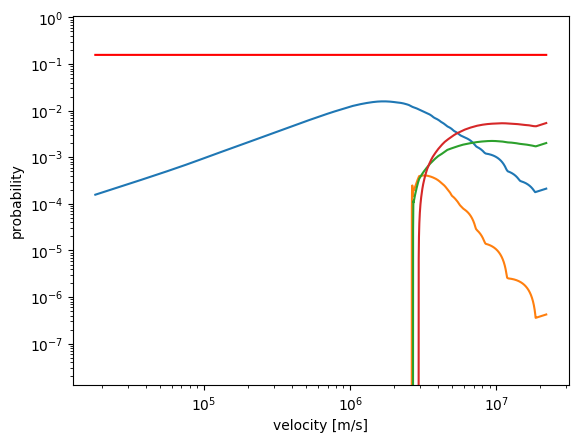

In [21]:
Pᵢ = zero(ν)
for (j, collision) in enumerate(electron.collisions)
	mᵢ = collision.source.m / 1.602176634e-19
	σᵢ = collision.rate
	εᵢ = 0.5 .* mᵢ .* ν .^ 2
	Pᵢ .+= 1.0 .- exp.(-n₀ .* ν .* σᵢ.(εᵢ) .* Δt)
    loglog(ν, 1.0 .- exp.(-n₀ .* ν .* σᵢ.(εᵢ) .* Δt))
end

loglog(ν, U .+ zero(ν), "r")
ylim(-0.1, +1.1)
xlabel("velocity [m/s]")
ylabel("probability")
nothing

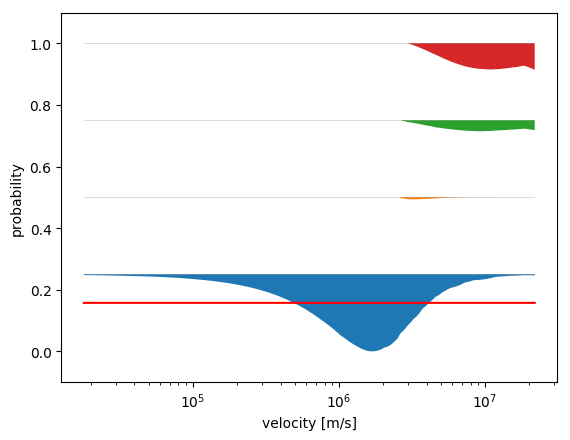

U > (i/N) - Pᵢ: σ: , e- + He-->e- + He	elastic (isotropic)


In [22]:
for (j, collision) in enumerate(electron.collisions)
	mᵢ = collision.source.m / 1.602176634e-19
	σᵢ = collision.rate
	εᵢ = 0.5 .* mᵢ .* ν .^ 2
	Pᵢ = (1.0 .- exp.(-n₀ .* ν .* σᵢ.(εᵢ) .* Δt)) ./ (N*Ptmax)
    #loglog(ν, n₀ .* ν .* σᵢ.(εᵢ) .* Δt)
    fill_between(ν, j/N, j/N .- Pᵢ)
    semilogx(ν, j/N .+ zero(ν), "k", linewidth=0.1)
    if i == j
      hit = U > i/N - maximum(Pᵢ)
      println("U > (i/N) - Pᵢ: ", hit ? collision : "null-collision")
    end
end

semilogx(ν, U .+ zero(ν), "r")
ylim(-0.1, +1.1)
xlabel("velocity [m/s]")
ylabel("probability")
nothing

In [7]:
sol = 299_792_458u"m/s" 
mass = 4.002602 * 931_494_028.23u"eV"/sol^2
energy = 10_000u"eV"
velocity = sqrt(2energy/mass)
#uconvert(u"kg", mass), 4.1484043136437294e-8 * 1.602176634e-19

LoadError: UndefVarError: @u_str not defined

In [8]:
vmin, vmax = 100, 700_000
timestep = 1.8436578171091445e-10
density = 9.64e20

ν = vmin:10_000.0:vmax
Δt = timestep
n₀ = density
N = 2
U = rand()
i = floor(Int64, N*U + 1)
println("U: ", U)
println("i: ", i)

Pt = zero(ν)

for collision in electron.collisions
	mᵢ = collision.source.m / 1.602176634e-19
	σᵢ = collision.rate
	εᵢ = 0.5 .* mᵢ .* ν .^ 2
  
    Pt .+= n₀ .* ν .* σᵢ.(εᵢ) .* Δt
end

Ptmax = maximum(Pt)
println("Ptmax: ", Ptmax)


U: 0.17553564459296145
i: 1


UndefVarError: UndefVarError: electron not defined

In [9]:
for (j, collision) in enumerate(ion.collisions)
	mᵢ = collision.source.m / 1.602176634e-19
	σᵢ = collision.rate
	εᵢ = 0.5 .* mᵢ .* ν .^ 2
	Pᵢ = n₀ .* ν .* σᵢ.(εᵢ) .* Δt ./ (N*Ptmax)
    #loglog(ν, σᵢ.(εᵢ) .* Δt)
    fill_between(ν, j/N, j/N .- Pᵢ)
    semilogx(ν, j/N .+ zero(ν), "k", linewidth=0.1)
    if i == j
      hit = U > i/N - maximum(Pᵢ)
      println("U > (i/N) - Pᵢ: ", hit ? collision : "null-collision")
    end
end
legend(string.(ion.collisions))
semilogx(ν, U .+ zero(ν), "r")
ylim(-0.01, +1.01)
xlabel("velocity [m/s]")
ylabel("probability")
nothing

UndefVarError: UndefVarError: ion not defined

In [10]:
Pᵢ = zero(ν)
for (j, collision) in enumerate(ion.collisions)
	mᵢ = collision.source.m / 1.602176634e-19
	σᵢ = collision.rate
	εᵢ = 0.5 .* mᵢ .* ν .^ 2
	Pᵢ = Pᵢ .+ n₀ .* ν .* σᵢ.(εᵢ) .* Δt
    loglog(ν, Pᵢ ./ Ptmax)
end

loglog(ν, U .+ zero(ν), "r")
ylim(-0.1, +1.1)
xlabel("velocity [m/s]")
ylabel("probability")
nothing

UndefVarError: UndefVarError: ion not defined